# Sieć służąca do klasyfikacji pastylek leków - detekcja oraz podsumowanie
Wykonał Bartłomiej Tarcholik

In [17]:
import numpy as np
import tensorflow as tf
import keras
import os
import shutil
from keras import layers
from keras import models
from matplotlib import pyplot as plt
import cv2

W celu detekcji używam lekko zmodyfikowanego algorytmu znajdowania bounding boxów.

In [69]:
def GetBoundingBoxes(image_to_get_bb, sizeToScale, t1, t2, testMode=False):
    x, y, z = image_to_get_bb.shape
    newX = 0
    newY = 0
    if x > y:
        newX = sizeToScale
        scale = newX / x
        newY = round(y * scale)
    else:
        newY = sizeToScale
        scale = newY / y
        newX = round(x * scale)
    res = cv2.resize(image_to_get_bb, (newY, newX), interpolation = cv2.INTER_AREA)
    img_blur = cv2.GaussianBlur(res, (3,3), 0, 0)
    edges = cv2.Canny(img_blur, threshold1=t1, threshold2=t2)
    if testMode:
        print("Edges:")
        plt.imshow(edges)
        plt.show()
    im_X, im_Y = edges.shape
    kernel = np.ones((5,5),np.uint8)
    dilation = cv2.dilate(edges,kernel,iterations = 1)
    if testMode:
        print("Dilatation:")
        plt.imshow(dilation)
        plt.show()
    ret, thresh = cv2.threshold(dilation, 127, 255, 0)
    contours, _ = cv2.findContours(thresh, cv2.RETR_TREE,
                                cv2.CHAIN_APPROX_SIMPLE)
    bboxes = []
    for i in range(len(contours)):
        cnt = contours[i]
        x, y, w, h = cv2.boundingRect(cnt)
        if w / im_X > 0.1 and h / im_Y:
            bbox = [[round(x / scale), round(y / scale)], [round((x + w)  / scale), round((y + h)  / scale)]]
            bboxes.append(bbox)
    toMerge = []
    unchanged = False
    while unchanged == False:
        unchanged = True
        for i in range(len(bboxes)):
            if unchanged:
                bbox = bboxes[i]
                start = bbox[0]
                end = bbox[1]
                add = True
                for j in range(len(bboxes)):
                    if i != j and unchanged:
                        other = bboxes[j]
                        st = other[0]
                        en = other[1]
                        dx = min(end[0], en[0]) - max(start[0], st[0])
                        dy = min(end[1], en[1]) - max(start[1], st[1])
                        if (dx>=0) and (dy>=0):
                            inter_area = dx * dy
                            smaller = min(
                            (end[0] - start[0]) * (end[1] - start[1]),
                            (en[0] - st[0]) * (en[1] - st[1])
                            )
                            if inter_area > (0.5 * smaller):
                                bboxes[i][0] = [min(start[0], st[0]), min(start[1], st[1])]
                                bboxes[i][1] = [max(end[0], en[0]), max(end[1], en[1])]
                                bboxes.pop(j)
                                unchanged = False
    for bbox in bboxes:
        xdif = bbox[1][0] - bbox[0][0]
        ydif = bbox[1][1] - bbox[0][1]
        val = round(abs(xdif - ydif) / 2)
        if xdif > ydif:
            y_start = bbox[0][1] - val
            y_end = bbox[1][1] + val
            if y_start < 0:
                offset = abs(y_start)
                y_start = 0
                y_end = y_end + offset
            elif y_end > image_to_get_bb.shape[1]:
                offset = y_end - image_to_get_bb.shape[1]
                y_end = image_to_get_bb.shape[1]
                y_start = y_start - offset
            bbox[0][1] = y_start
            bbox[1][1] = y_end
        else:
            x_start = bbox[0][0] - val
            x_end = bbox[1][0] + val
            if x_start < 0:
                offset = abs(x_start)
                x_start = 0
                x_end = x_end + offset
            elif x_end > image_to_get_bb.shape[0]:
                offset = x_end - image_to_get_bb.shape[0]
                x_end = image_to_get_bb.shape[0]
                x_start = x_start - offset
            bbox[0][0] = x_start
            bbox[1][0] = x_end
    return bboxes

Detekcja polega na znalezieniu bounding boxów, a następnie predykcji dla każdego z nich. W przypadku pewności poniżej 40% uznaję bounding box za tło.

In [80]:
from tensorflow.keras.preprocessing import image as image_preprocessor

def WhatIsOnThePhoto(img, model):
  bboxes = GetBoundingBoxes(img, 300, 50, 100)
  print(len(bboxes))
  results = []
  labels = ["capsule", "flat-capsule", "oval", "oval-capsule", "round", "square"]
  for bx in bboxes:
    im = img[bx[0][1]:bx[1][1], bx[0][0]:bx[1][0]]
    res = cv2.resize(im, (64, 64), interpolation=cv2.INTER_AREA)
    img_tensor = image_preprocessor.img_to_array(res)
    img_tensor = np.expand_dims(img_tensor, axis=0)
    img_tensor /= 255.
    predictions = model.predict(img_tensor, verbose=0)[0]
    label = labels[np.argmax(predictions)]
    condifence = predictions[np.argmax(predictions)]
    if condifence < 0.4:
      label = "Nothing"
    predicted = [bx, label, condifence]
    results.append(predicted)
  return results
    

4


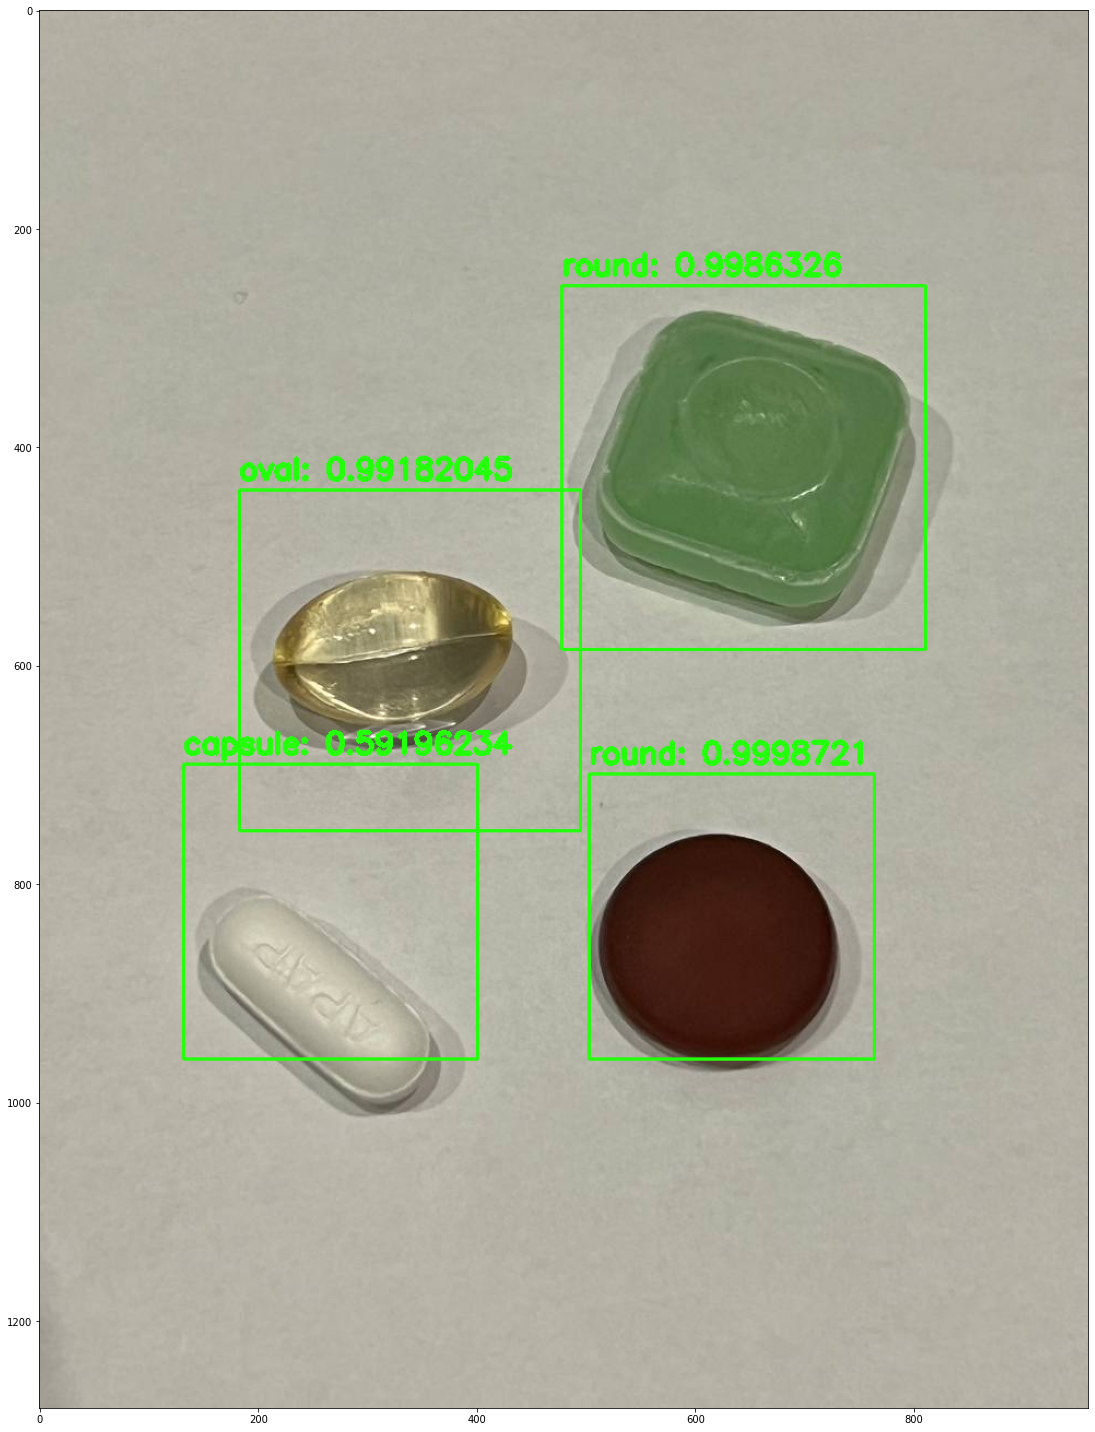

In [81]:
from keras.models import load_model
model = load_model('C:/ml/models/pills_final_ranking/4.h5')
image = cv2.imread("C:/ml/data/pills/test/flat-capsule_round_square_oval-capsule.jpg")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
results = WhatIsOnThePhoto(image, model)

newImage = cv2.imread("C:/ml/data/pills/test/flat-capsule_round_square_oval-capsule.jpg")
newImage = cv2.cvtColor(newImage, cv2.COLOR_BGR2RGB)
for result in results:
  bbox = result[0]
  label = result[1]
  confidence = result[2]
  newImage = cv2.rectangle(newImage, (bbox[0][0], bbox[0][1]), (bbox[1][0], bbox[1][1]), (36,255,12), 2)
  cv2.putText(newImage, label + ": " + str(confidence), (bbox[0][0], bbox[0][1]-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (36,255,12), 3)

plt.figure(figsize=(20, 20))
plt.imshow(newImage)

plt.show()

4


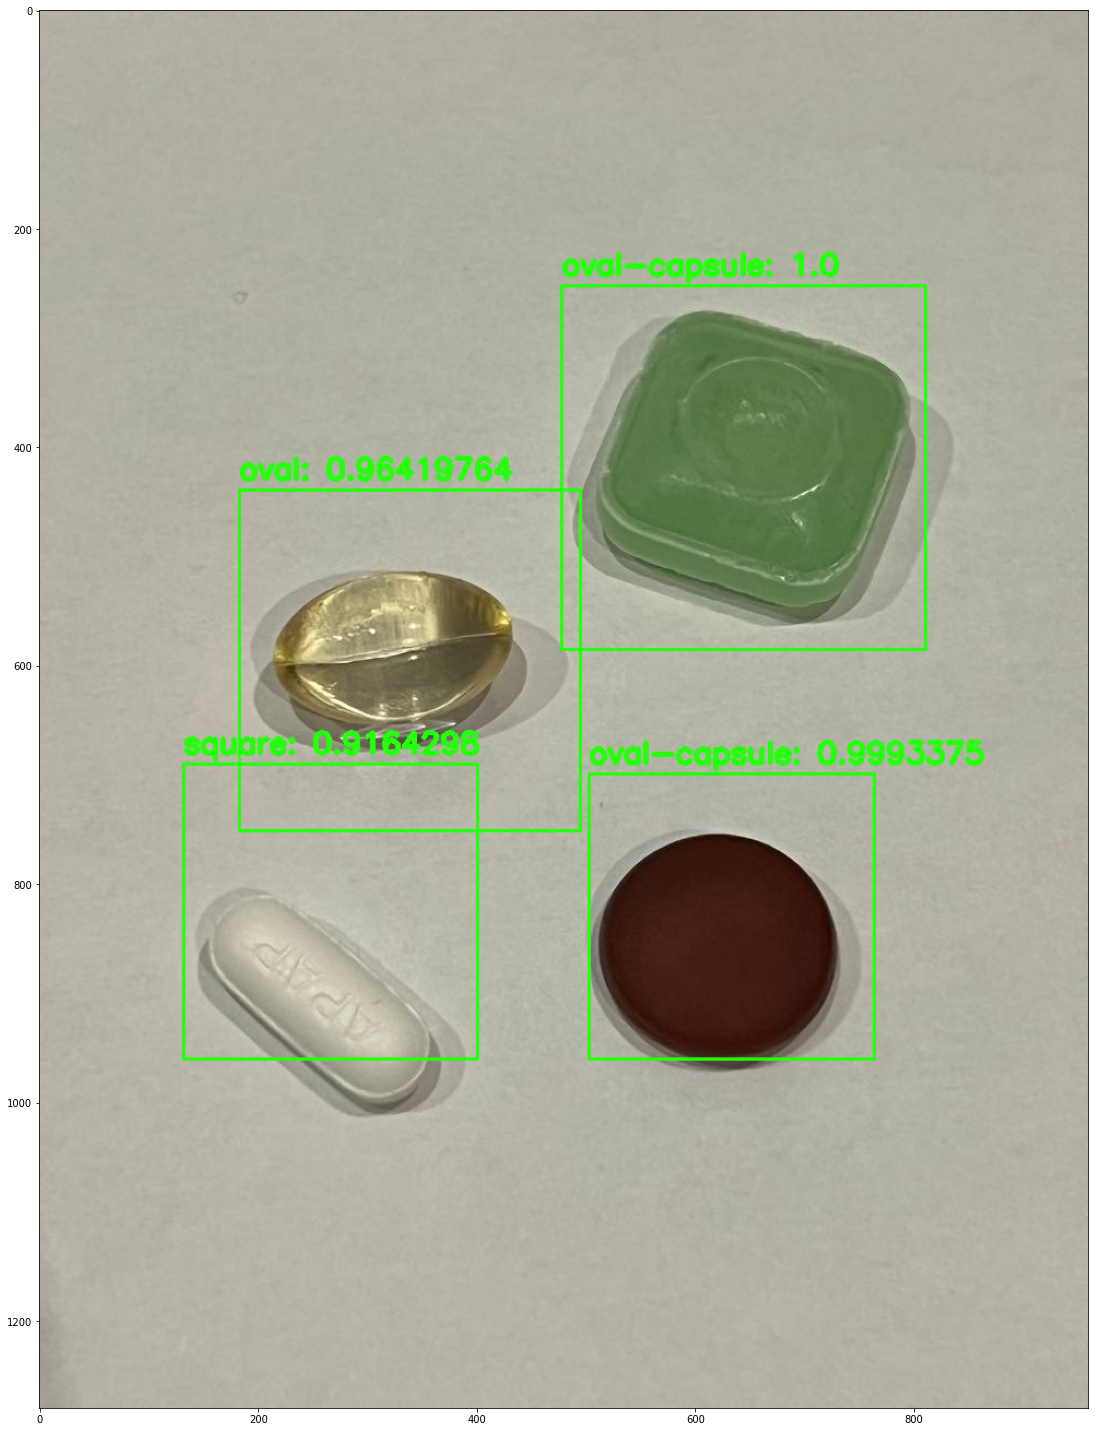

In [82]:
from keras.models import load_model
model = load_model('C:/ml/models/pills_final_ranking/1.h5')
image = cv2.imread("C:/ml/data/pills/test/flat-capsule_round_square_oval-capsule.jpg")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
results = WhatIsOnThePhoto(image, model)

newImage = cv2.imread("C:/ml/data/pills/test/flat-capsule_round_square_oval-capsule.jpg")
newImage = cv2.cvtColor(newImage, cv2.COLOR_BGR2RGB)
for result in results:
  bbox = result[0]
  label = result[1]
  confidence = result[2]
  newImage = cv2.rectangle(newImage, (bbox[0][0], bbox[0][1]), (bbox[1][0], bbox[1][1]), (36,255,12), 2)
  cv2.putText(newImage, label + ": " + str(confidence), (bbox[0][0], bbox[0][1]-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (36,255,12), 3)

plt.figure(figsize=(20, 20))
plt.imshow(newImage)

plt.show()

4


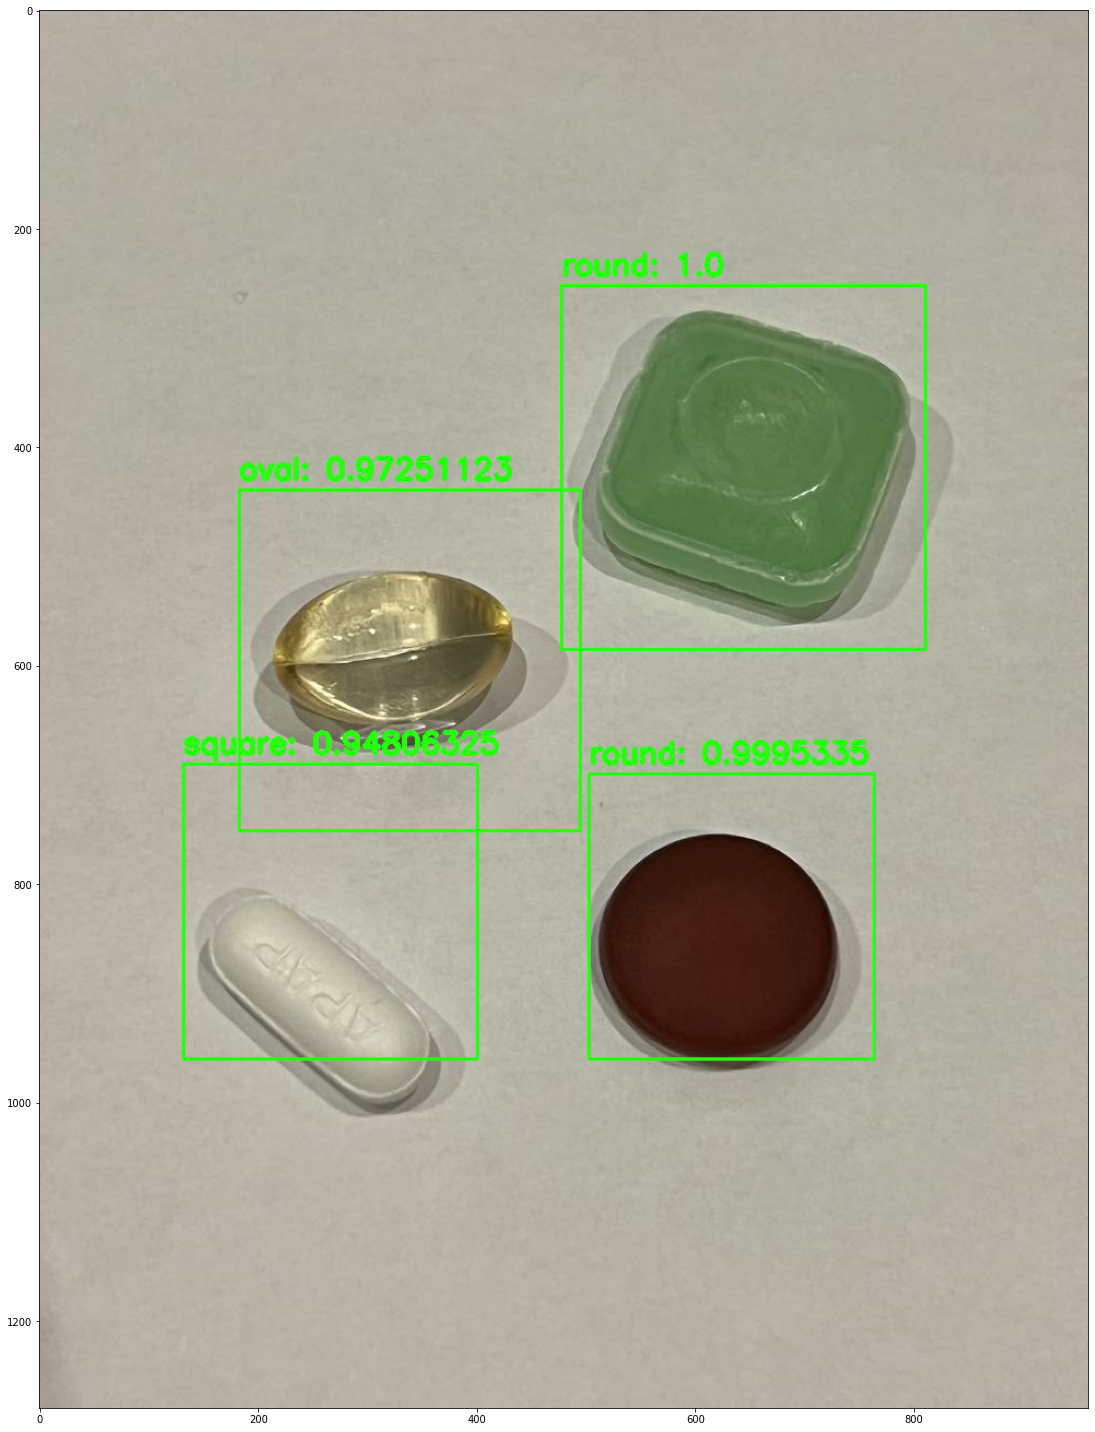

In [83]:
model = load_model('C:/ml/models/pills_final_ranking/2.h5')
image = cv2.imread("C:/ml/data/pills/test/flat-capsule_round_square_oval-capsule.jpg")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
results = WhatIsOnThePhoto(image, model)

newImage = cv2.imread("C:/ml/data/pills/test/flat-capsule_round_square_oval-capsule.jpg")
newImage = cv2.cvtColor(newImage, cv2.COLOR_BGR2RGB)
for result in results:
  bbox = result[0]
  label = result[1]
  confidence = result[2]
  newImage = cv2.rectangle(newImage, (bbox[0][0], bbox[0][1]), (bbox[1][0], bbox[1][1]), (36,255,12), 2)
  cv2.putText(newImage, label + ": " + str(confidence), (bbox[0][0], bbox[0][1]-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (36,255,12), 3)

plt.figure(figsize=(20, 20))
plt.imshow(newImage)

plt.show()

4


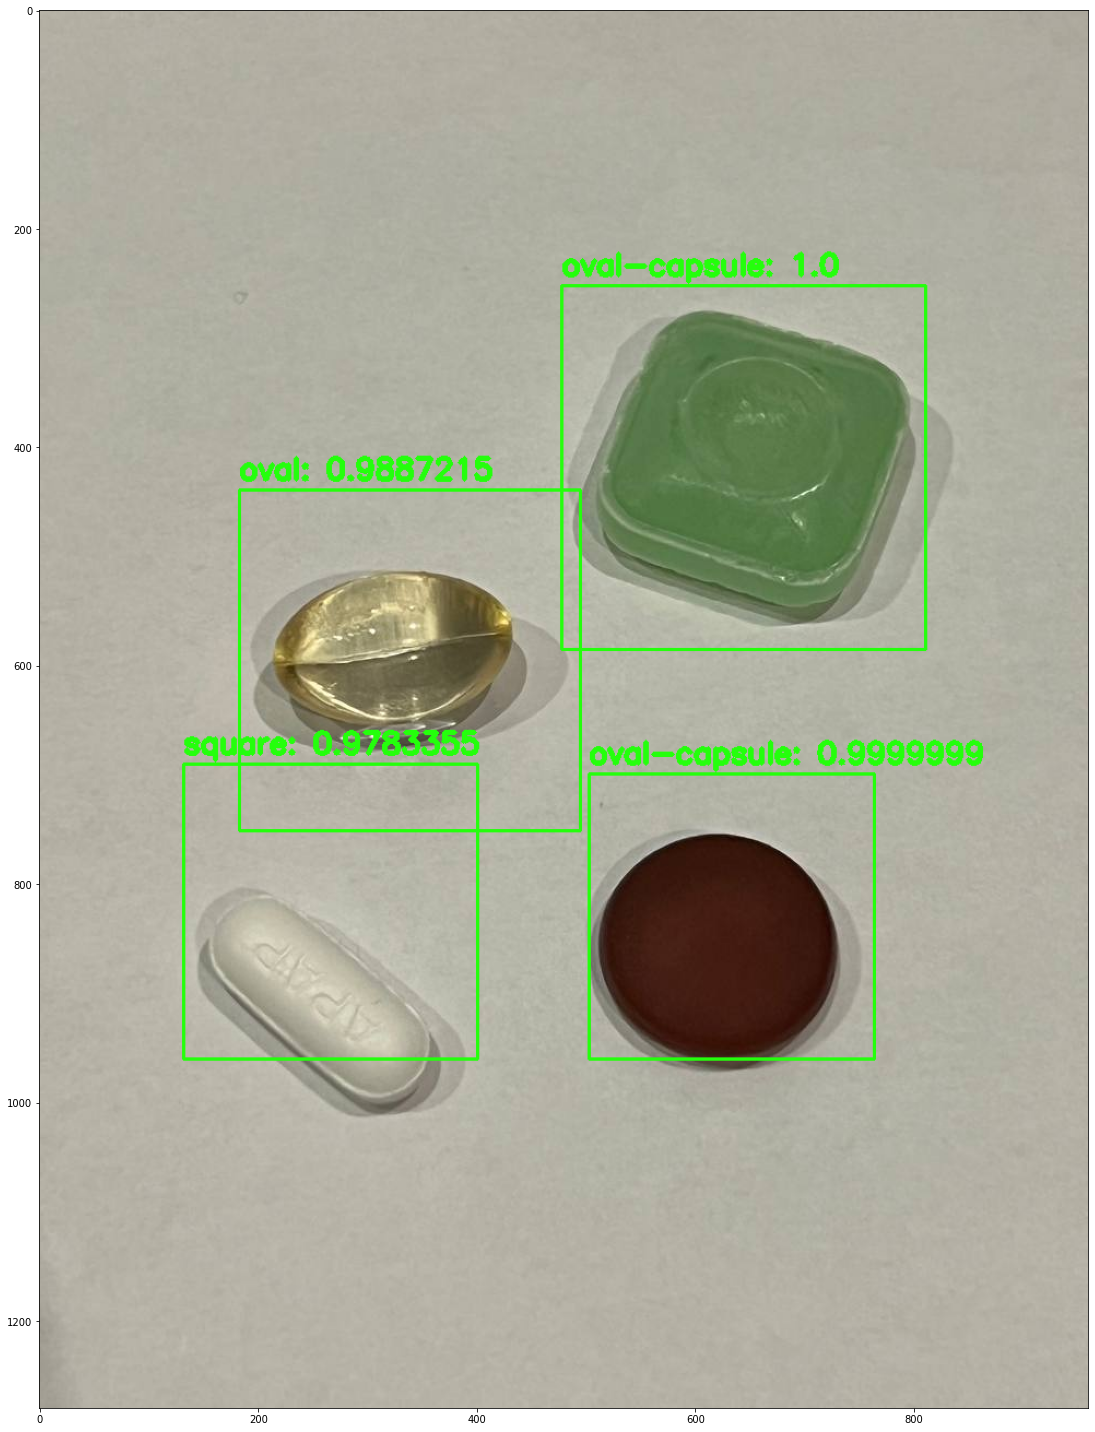

In [84]:
model = load_model('C:/ml/models/pills_final_ranking/3.h5')
image = cv2.imread("C:/ml/data/pills/test/flat-capsule_round_square_oval-capsule.jpg")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
results = WhatIsOnThePhoto(image, model)

newImage = cv2.imread("C:/ml/data/pills/test/flat-capsule_round_square_oval-capsule.jpg")
newImage = cv2.cvtColor(newImage, cv2.COLOR_BGR2RGB)
for result in results:
  bbox = result[0]
  label = result[1]
  confidence = result[2]
  newImage = cv2.rectangle(newImage, (bbox[0][0], bbox[0][1]), (bbox[1][0], bbox[1][1]), (36,255,12), 2)
  cv2.putText(newImage, label + ": " + str(confidence), (bbox[0][0], bbox[0][1]-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (36,255,12), 3)

plt.figure(figsize=(20, 20))
plt.imshow(newImage)

plt.show()

4


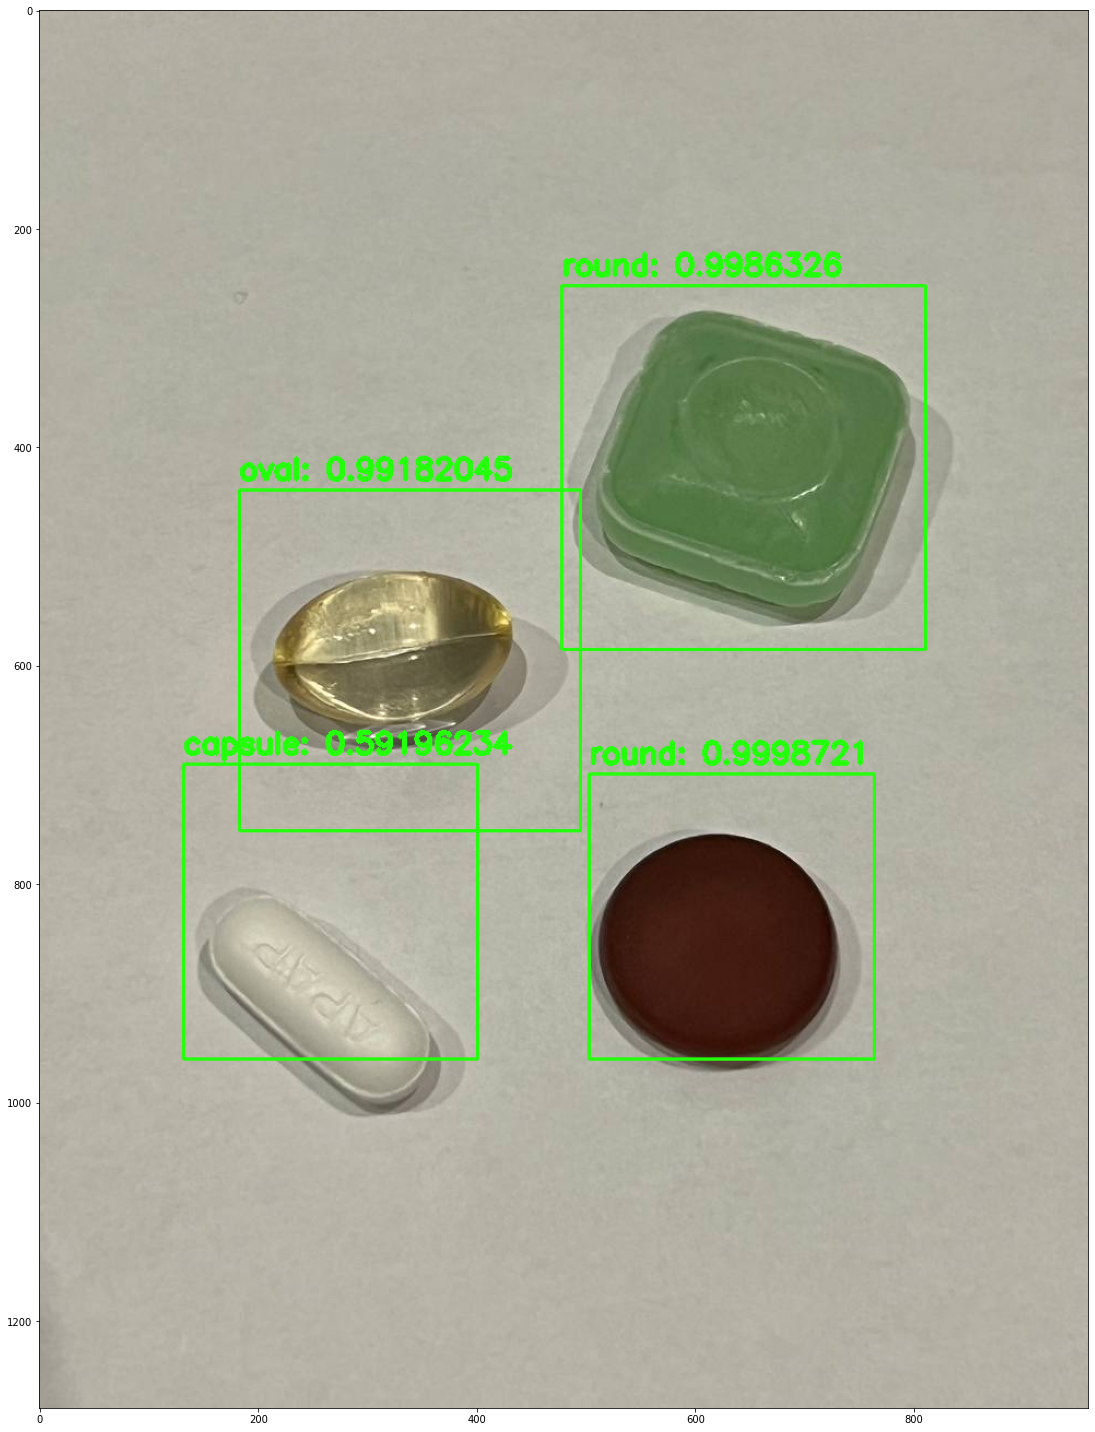

In [85]:
from keras.models import load_model
model = load_model('C:/ml/models/pills_final_ranking/4.h5')
image = cv2.imread("C:/ml/data/pills/test/flat-capsule_round_square_oval-capsule.jpg")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
results = WhatIsOnThePhoto(image, model)

newImage = cv2.imread("C:/ml/data/pills/test/flat-capsule_round_square_oval-capsule.jpg")
newImage = cv2.cvtColor(newImage, cv2.COLOR_BGR2RGB)
for result in results:
  bbox = result[0]
  label = result[1]
  confidence = result[2]
  newImage = cv2.rectangle(newImage, (bbox[0][0], bbox[0][1]), (bbox[1][0], bbox[1][1]), (36,255,12), 2)
  cv2.putText(newImage, label + ": " + str(confidence), (bbox[0][0], bbox[0][1]-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (36,255,12), 3)

plt.figure(figsize=(20, 20))
plt.imshow(newImage)

plt.show()

4


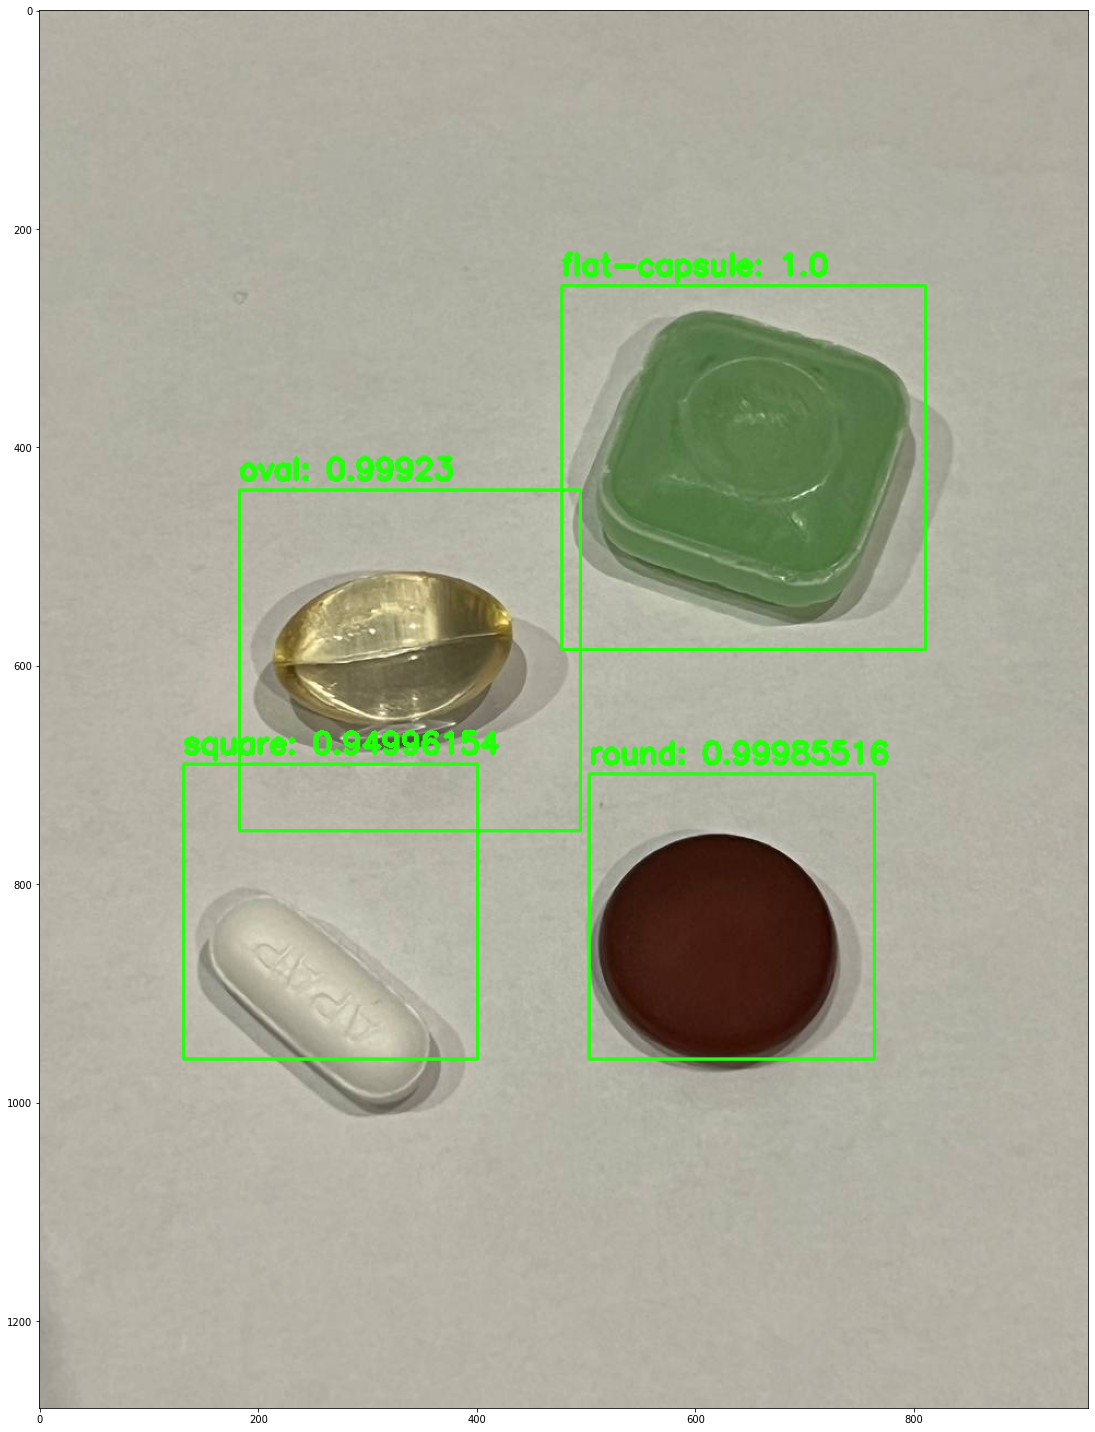

In [86]:
from keras.models import load_model
model = load_model('C:/ml/models/pills_final_ranking/5.h5')
image = cv2.imread("C:/ml/data/pills/test/flat-capsule_round_square_oval-capsule.jpg")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
results = WhatIsOnThePhoto(image, model)

newImage = cv2.imread("C:/ml/data/pills/test/flat-capsule_round_square_oval-capsule.jpg")
newImage = cv2.cvtColor(newImage, cv2.COLOR_BGR2RGB)
for result in results:
  bbox = result[0]
  label = result[1]
  confidence = result[2]
  newImage = cv2.rectangle(newImage, (bbox[0][0], bbox[0][1]), (bbox[1][0], bbox[1][1]), (36,255,12), 2)
  cv2.putText(newImage, label + ": " + str(confidence), (bbox[0][0], bbox[0][1]-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (36,255,12), 3)

plt.figure(figsize=(20, 20))
plt.imshow(newImage)

plt.show()

## Analiza detekcji
Na przykładzie tego jednego zdjęcia potwierdzają się przypuszczenia, że jedyną siecią jakkolwiek zdolną do przybliżonej klasyfikacji dla tego problemu jest sieć na miejscu 4, czyli 1 warstwa Conv2d z 32 neuronami, 1 z 64 neuronami, 1 z 128 neuronami oraz 2 warstwy po 256 neuronów, 256 neuronów gęstych, funkcja aktywacji Leaky ReLU oraz optymalizator RMSProp, trenowana przez 96 epok. Cała reszta klasyfikuje w bardzo mylne sposoby, jedynie sieć 4. "myśli" prawidłowo i mimo popełniania błędów, są one w pełni wytłumaczalne.

## Wnioski
Niestety wytrenowane przeze mnie sieci cierpią z dwóch ważnych powodów:
1. Mała wielkość datasetu powoduje bardzo problematyczne uczenie - overfitting jest właściwie pewnością, a ilość cech, które można zdobyć z takiego zestawu danych jest drastycznie ograniczona
2. Mój własny błąd w trakcie przygotowania danych - przez przypadek przeskalowałem obrazy do wielkości 75x75 pikseli, ale trening odbywał się na kształcie 64x64. Niewątpliwie spowodowało to pewne problemy i powinno się to zmienić przed ponownym treningiem. Niestety zabrakło mi na to czasu.
Na dodatek algorytm znajdowania bounding boxów zdecydowanie potrzebuje rewizji.

Oprócz tego jestem jednak skłonny stwierdzić, że wykonana praca jest sporym postępem w tworzeniu tej aplikacji, a podstawy są całkiem niezłe. Jak widać na powyższym obrazku, sieć 4. może i nie znajduje właściwej klasy w 3/4 przypadkach, ale każdy jest kompletnie spoza datasetu. Znajdowane kształty są jednak wytłumaczalne, dlaczego sieć mogła je wybrać.

# Czego się nauczyłem przez ten semestr
W poprzednim semestrze wszyscy mieliśmy możliwość uczęszczania na zajęcia z Uczenia Maszynowego, na których mieliśmy pierwszy realny wstęp do sieci neuronowych, lecz w bardzo przyspieszonym tempie. W tym semestrze byłem w stanie w dużym stopniu zrozumieć sieci neuronowe, ich zasadę działania, co jest w nich ważne, sposoby ich właściwego tworzenia oraz analizy.

Przedmiot ten bardzo szybko stał się moim ulubionym na tym semestrze (aczkolwiek może nie jest to fair porównanie, bo poprzeczka tego semestru jest dosyć nisko...), a nawet w całym dotychczasowym programie studiów. Zdecydowanie najważniejsze było dla mnie poznanie CNN, zrozumiałem też, że będą to najprawdopodobniej najczęstsze sieci, z jakimi będę miał przyjemność pracować. Mam wielką nadzieję na kontynuację nauki na przedmiocie w następnym semestrze oraz rozwinięcia projektów takich jak ten.
Jeśli chodzi o uwagi odnośnie prowadzenia przedmiotu, to szczerze ciężko cokolwiek zarzucić. Wykłady były wyśmienicie ciekawe, zaś zadania dobre. Jedynie prosiłbym o więcej CNN w zadaniach.

Pozytywne cechy przedmiotu:
- Zdecydowanie najlepiej prowadzone wykłady na AGH z mojego dotychczasowego doświadczenia. Nie było minuty, gdzie nie siedziałbym zaciekawiony. Informacje były prezentowane w bardzo przystępny sposób, a prowadzący znakomicie tłumaczył wszystkie zagadnienia.
- Znakomicie przemyślane zadania w formie Jupyter Notebooków, które w bardzo dobry i obszerny sposób wyjaśniały zagadnienie
- Ciekawy projekt z kompletną dowolnością
- Wyrozumiałość prowadzącego wobec problemów studentów
- Chęć pomocy prowadzącego w przypadku problemów

Negatywne cechy przedmiotu:
- Niewystarczający czas poświęcony sieciom konwolucyjnym
- Sugestia użycia prezentacji PowerPointa jako formy raportu z projektu ;) (miejmy nadzieję, że w istocie sugestia, a nie wymaganie...)